In [1]:
import torch

if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print(x)
else:
    print("MPS device not found.")


tensor([1.], device='mps:0')


In [2]:
# Import essential libraries
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style='darkgrid')
import copy # A module that provides functions for creating copies of objects, useful for avoiding unintended modifications to variables.
import os # A module that provides a way to interact with the operating system, allowing for tasks such as file and directory manipulation.
import torch
from PIL import Image # A module from the Python Imaging Library (PIL) that provides functionality for opening, manipulating, and saving various image file formats.
from torch.utils.data import Dataset # A PyTorch class that represents a dataset and provides an interface for accessing and processing the data during training.
import torchvision
import torchvision.transforms as transforms # A module from the torchvision library that provides common image transformations, such as resizing, cropping, and normalization.
from torch.utils.data import random_split # A function from PyTorch that allows for randomly splitting a dataset into training and validation subsets.
from torch.optim.lr_scheduler import ReduceLROnPlateau # A PyTorch scheduler that adjusts the learning rate during training based on a specified metric, reducing it when the metric plateaus.
import torch.nn as nn # A module in PyTorch that provides classes for defining and building neural networks.
from torchvision import utils # A module from torchvision that contains utility functions for working with images, such as saving and visualizing them.
from torchvision.datasets import ImageFolder
import splitfolders
from torchsummary import summary
import torch.nn.functional as F
import pathlib
from sklearn.metrics import confusion_matrix, classification_report
import itertools # This import statement imports the itertools module, which provides functions for efficient looping and combining of iterables. It can be used for tasks such as generating combinations or permutations of elements.
from tqdm.notebook import trange, tqdm # These functions allow for the creation of progress bars to track the progress of loops or tasks.
from torch import optim
import warnings
warnings.filterwarnings('ignore')

Load Dataset

In [3]:
labels_df = pd.read_csv('data/metadata.csv')

In [4]:
print(labels_df.head().to_markdown())

|    |   Unnamed: 0 | image                  | class    | format   | mode   | shape         |
|---:|-------------:|:-----------------------|:---------|:---------|:-------|:--------------|
|  0 |            0 | Schizophrenia (1).jpg  | infected | JPEG     | RGB    | (512, 512, 3) |
|  1 |            1 | Schizophrenia (1).png  | infected | PNG      | L      | (300, 240)    |
|  2 |            2 | Schizophrenia (1).tif  | infected | TIFF     | RGB    | (256, 256, 3) |
|  3 |            3 | Schizophrenia (10).jpg | infected | JPEG     | RGB    | (512, 512, 3) |
|  4 |            4 | Schizophrenia (10).tif | infected | TIFF     | RGB    | (256, 256, 3) |


In [5]:
print(labels_df.tail().to_markdown())

|      |   Unnamed: 0 | image                        | class   | format   | mode   | shape         |
|-----:|-------------:|:-----------------------------|:--------|:---------|:-------|:--------------|
| 4595 |         4595 | Not Schizophrenia  (995).jpg | normal  | JPEG     | RGB    | (168, 300, 3) |
| 4596 |         4596 | Not Schizophrenia  (996).jpg | normal  | JPEG     | RGB    | (509, 452, 3) |
| 4597 |         4597 | Not Schizophrenia  (997).jpg | normal  | JPEG     | RGB    | (197, 177, 3) |
| 4598 |         4598 | Not Schizophrenia  (998).jpg | normal  | JPEG     | RGB    | (217, 232, 3) |
| 4599 |         4599 | Not Schizophrenia  (999).jpg | normal  | JPEG     | RGB    | (221, 228, 3) |


In [6]:
labels_df.shape

(4600, 6)

Data Preparation

In [7]:
# Dataset Path
data_dir = 'data/Schizophrenia Data Set/Schizophrenia Data Set'
data_dir = pathlib.Path(data_dir)

# Splitting dataset to train_set, val_set and test_set
splitfolders.ratio(data_dir, output='brain', seed=20, ratio=(0.8, 0.2))


# New dataset path
data_dir = 'brain'
data_dir = pathlib.Path(data_dir)

Copying files: 4600 files [00:00, 5065.88 files/s]


Image Augmentation Definitions

In [8]:
# define transformation
transform = transforms.Compose(
    [
        transforms.Resize((256,256)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomRotation(30),
        transforms.ToTensor(),
        transforms.Normalize(mean = [0.485, 0.456, 0.406],std = [0.229, 0.224, 0.225])
   ]
)

In [9]:
# Define an object of the custom dataset for the train and validation.
train_set = torchvision.datasets.ImageFolder(data_dir.joinpath("train"), transform=transform) 
train_set.transform
val_set = torchvision.datasets.ImageFolder(data_dir.joinpath("val"), transform=transform)
val_set.transform

Compose(
    Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=True)
    RandomHorizontalFlip(p=0.5)
    RandomVerticalFlip(p=0.5)
    RandomRotation(degrees=[-30.0, 30.0], interpolation=nearest, expand=False, fill=0)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

In [10]:
pip install --upgrade tqdm


Note: you may need to restart the kernel to use updated packages.


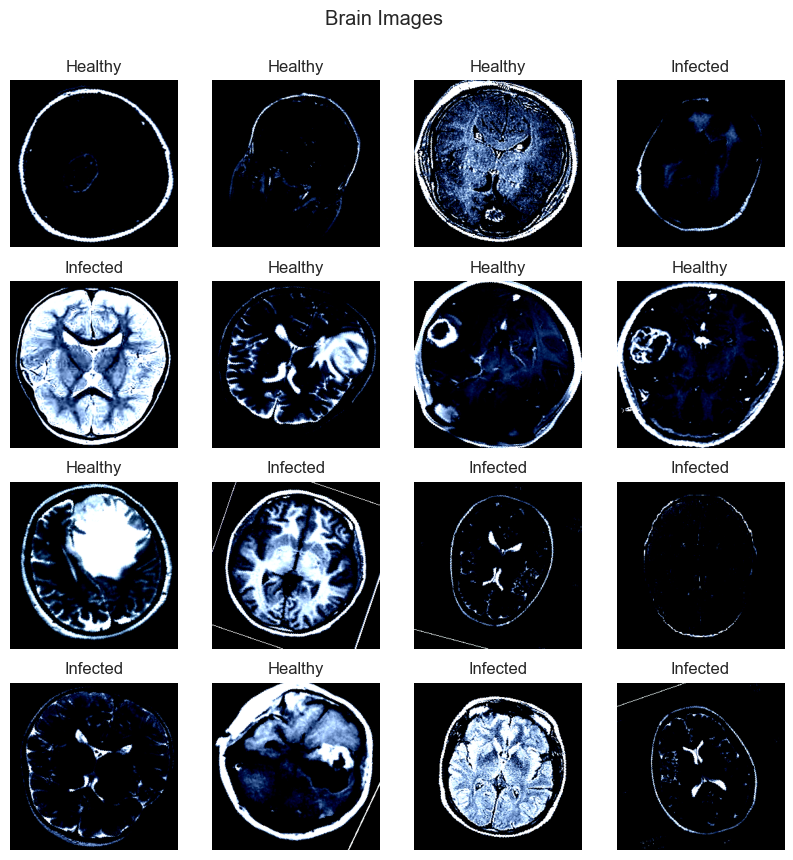

In [11]:
# Visualiztion some images from Train Set
CLA_label = {
    0 : 'Infected',
    1 : 'Healthy'
} 
figure = plt.figure(figsize=(10, 10))
cols, rows = 4, 4
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_set), size=(1,)).item()
    img, label = train_set[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(CLA_label[label])
    plt.axis("off")
    img_np = img.numpy().transpose((1, 2, 0))
    # Clip pixel values to [0, 1]
    img_valid_range = np.clip(img_np, 0, 1)
    plt.imshow(img_valid_range)
    plt.suptitle('Brain Images', y=0.95)
plt.show()

Creating Dataloaders

In [12]:
# import and load train, validation
batch_size = 60

train_loader = torch.utils.data.DataLoader(train_set, batch_size = batch_size, shuffle = True, num_workers = 2)
val_loader = torch.utils.data.DataLoader(val_set, batch_size = batch_size, shuffle = True, num_workers = 2)


In [13]:
# print shape for Training data and Validation data
for key, value in {'Training data': train_loader, "Validation data": val_loader}.items():
    for X, y in value:
        print(f"{key}:")
        print(f"Shape of X : {X.shape}")
        print(f"Shape of y: {y.shape} {y.dtype}\n")
        break

Training data:
Shape of X : torch.Size([60, 3, 256, 256])
Shape of y: torch.Size([60]) torch.int64

Validation data:
Shape of X : torch.Size([60, 3, 256, 256])
Shape of y: torch.Size([60]) torch.int64



Define Brain Schizophrenia Classifier

In [14]:
'''This function can be useful in determining the output size of a convolutional layer in a neural network,
given the input dimensions and the convolutional layer's parameters.'''

def findConv2dOutShape(hin,win,conv,pool=2):
    # get conv arguments
    kernel_size = conv.kernel_size
    stride=conv.stride
    padding=conv.padding
    dilation=conv.dilation

    hout=np.floor((hin+2*padding[0]-dilation[0]*(kernel_size[0]-1)-1)/stride[0]+1)
    wout=np.floor((win+2*padding[1]-dilation[1]*(kernel_size[1]-1)-1)/stride[1]+1)

    if pool:
        hout/=pool
        wout/=pool
    return int(hout),int(wout)

In [15]:
# Define Architecture For CNN_Schizophrenia Model
class CNN_Schizophrenia(nn.Module):
    
    # Network Initialisation
    def __init__(self, params):
        
        super(CNN_Schizophrenia, self).__init__()
    
        Cin,Hin,Win = params["shape_in"]
        init_f = params["initial_filters"] 
        num_fc1 = params["num_fc1"]  
        num_classes = params["num_classes"] 
        self.dropout_rate = params["dropout_rate"] 
        
        # Convolution Layers
        self.conv1 = nn.Conv2d(Cin, init_f, kernel_size=3)
        h,w=findConv2dOutShape(Hin,Win,self.conv1)
        self.conv2 = nn.Conv2d(init_f, 2*init_f, kernel_size=3)
        h,w=findConv2dOutShape(h,w,self.conv2)
        self.conv3 = nn.Conv2d(2*init_f, 4*init_f, kernel_size=3)
        h,w=findConv2dOutShape(h,w,self.conv3)
        self.conv4 = nn.Conv2d(4*init_f, 8*init_f, kernel_size=3)
        h,w=findConv2dOutShape(h,w,self.conv4)
        
        # compute the flatten size
        self.num_flatten=h*w*8*init_f
        self.fc1 = nn.Linear(self.num_flatten, num_fc1)
        self.fc2 = nn.Linear(num_fc1, num_classes)

    def forward(self,X):
        
        # Convolution & Pool Layers
        X = F.relu(self.conv1(X)); 
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv3(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv4(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, self.num_flatten)
        X = F.relu(self.fc1(X))
        X = F.dropout(X, self.dropout_rate)
        X = self.fc2(X)
        return F.log_softmax(X, dim=1)

In [16]:
params_model={
        "shape_in": (3,256,256), 
        "initial_filters": 8,    
        "num_fc1": 100,
        "dropout_rate": 0.25,
        "num_classes": 2}

# Create instantiation of Network class
cnn_model = CNN_Schizophrenia(params_model)

# define computation hardware approach (GPU/CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = cnn_model.to(device)

In [17]:
# Model Summary for CNN Model
summary(cnn_model, input_size=(3, 256, 256),device=device.type)

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            224
├─Conv2d: 1-2                            1,168
├─Conv2d: 1-3                            4,640
├─Conv2d: 1-4                            18,496
├─Linear: 1-5                            1,254,500
├─Linear: 1-6                            202
Total params: 1,279,230
Trainable params: 1,279,230
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            224
├─Conv2d: 1-2                            1,168
├─Conv2d: 1-3                            4,640
├─Conv2d: 1-4                            18,496
├─Linear: 1-5                            1,254,500
├─Linear: 1-6                            202
Total params: 1,279,230
Trainable params: 1,279,230
Non-trainable params: 0

Loss Function Definition

In [18]:
loss_func = nn.NLLLoss(reduction="sum")

Optimiser Definition

In [19]:
opt = optim.Adam(cnn_model.parameters(), lr=3e-4)
lr_scheduler = ReduceLROnPlateau(opt, mode='min',factor=0.5, patience=20,verbose=1)

Training Model

In [20]:
# Function to get the learning rate
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']

# Function to compute the loss value per batch of data
def loss_batch(loss_func, output, target, opt=None):
    
    loss = loss_func(output, target) # get loss
    pred = output.argmax(dim=1, keepdim=True) # Get Output Class
    metric_b=pred.eq(target.view_as(pred)).sum().item() # get performance metric
    
    if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()

    return loss.item(), metric_b

def loss_epoch(model, loss_func, dataset_dl, opt=None):
    running_loss = 0.0
    running_metric = 0.0
    len_data = len(dataset_dl.dataset)

    for xb, yb in dataset_dl:
        # move the data and labels to the MPS device
        xb = xb.to(mps_device)
        yb = yb.to(mps_device)
        
        # get model output
        output = model(xb)

        # get loss per batch
        loss_b, metric_b = loss_batch(loss_func, output, yb, opt)

        # update running loss
        running_loss += loss_b

        # update running metric
        if metric_b is not None:
            running_metric += metric_b

    # average loss value
    loss = running_loss / len_data
    metric = running_metric / len_data

    return loss, metric


Training Function

In [21]:
import torch
import copy
from tqdm import tqdm

# Check if MPS (Metal Performance Shaders) is available
mps_device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

def Train_Val(model, params, verbose=False):
    
    # Get the parameters
    epochs = params["epochs"]
    loss_func = params["f_loss"]
    opt = params["optimiser"]
    train_dl = params["train"]
    val_dl = params["val"]
    lr_scheduler = params["lr_change"]
    weight_path = params["weight_path"]
    
    # Move the model to the MPS device
    model = model.to(mps_device)
    
    # history of loss values in each epoch
    loss_history = {"train": [], "val": []} 
    # history of metric values in each epoch
    metric_history = {"train": [], "val": []} 
    # a deep copy of weights for the best performing model
    best_model_wts = copy.deepcopy(model.state_dict()) 
    # initialize best loss to a large value
    best_loss = float('inf') 

    # Train Model n_epochs
    for epoch in tqdm(range(epochs)):
        
        # Get the Learning Rate
        current_lr = get_lr(opt)
        if verbose:
            print('Epoch {}/{}, current lr={}'.format(epoch, epochs - 1, current_lr))

        # Train Model Process
        model.train()
        train_loss, train_metric = loss_epoch(model, loss_func, train_dl, opt)

        # collect losses
        loss_history["train"].append(train_loss)
        metric_history["train"].append(train_metric)
        
        # Evaluate Model Process
        model.eval()
        with torch.no_grad():
            val_loss, val_metric = loss_epoch(model, loss_func, val_dl)
        
        # store best model
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            
            # store weights into a local file
            torch.save(model.state_dict(), weight_path)
            if verbose:
                print("Copied best model weights!")
        
        # collect loss and metric for validation dataset
        loss_history["val"].append(val_loss)
        metric_history["val"].append(val_metric)
        
        # learning rate schedule
        lr_scheduler.step(val_loss)
        if current_lr != get_lr(opt):
            if verbose:
                print("Loading best model weights!")
            model.load_state_dict(best_model_wts) 

        if verbose:
            print(f"train loss: {train_loss:.6f}, dev loss: {val_loss:.6f}, accuracy: {100*val_metric:.2f}")
            print("-"*10) 

    # load best model weights
    model.load_state_dict(best_model_wts)
        
    return model, loss_history, metric_history


Training Process

In [22]:
# Define various parameters used for training and evaluation of a cnn_model

params_train={
 "train": train_loader,"val": val_loader,
 "epochs": 60,
 "optimiser": optim.Adam(cnn_model.parameters(),lr=3e-4),
 "lr_change": ReduceLROnPlateau(opt,
                                mode='min',
                                factor=0.5,
                                patience=20,
                                verbose=0),
 "f_loss": nn.NLLLoss(reduction="sum"),
 "weight_path": "weights.pt",
}

# train and validate the model
cnn_model,loss_hist,metric_hist = Train_Val(cnn_model, params_train, verbose=True)



  0%|          | 0/60 [00:00<?, ?it/s]

Epoch 0/59, current lr=0.0003


  2%|▏         | 1/60 [00:31<31:03, 31.59s/it]

Copied best model weights!
train loss: 0.620876, dev loss: 0.573003, accuracy: 71.66
----------
Epoch 1/59, current lr=0.0003


  3%|▎         | 2/60 [01:02<30:13, 31.27s/it]

Copied best model weights!
train loss: 0.518860, dev loss: 0.464588, accuracy: 79.04
----------
Epoch 2/59, current lr=0.0003


  5%|▌         | 3/60 [01:34<29:47, 31.36s/it]

Copied best model weights!
train loss: 0.441704, dev loss: 0.423067, accuracy: 80.67
----------
Epoch 3/59, current lr=0.0003


  7%|▋         | 4/60 [02:05<29:17, 31.39s/it]

Copied best model weights!
train loss: 0.377682, dev loss: 0.377383, accuracy: 83.93
----------
Epoch 4/59, current lr=0.0003


  8%|▊         | 5/60 [02:37<28:47, 31.42s/it]

train loss: 0.344495, dev loss: 0.384748, accuracy: 84.69
----------
Epoch 5/59, current lr=0.0003


 10%|█         | 6/60 [03:08<28:21, 31.50s/it]

Copied best model weights!
train loss: 0.321474, dev loss: 0.329591, accuracy: 85.56
----------
Epoch 6/59, current lr=0.0003


 12%|█▏        | 7/60 [03:40<27:49, 31.49s/it]

train loss: 0.320962, dev loss: 0.332610, accuracy: 84.80
----------
Epoch 7/59, current lr=0.0003


 13%|█▎        | 8/60 [04:11<27:18, 31.50s/it]

Copied best model weights!
train loss: 0.293165, dev loss: 0.291275, accuracy: 87.51
----------
Epoch 8/59, current lr=0.0003


 15%|█▌        | 9/60 [04:43<26:46, 31.50s/it]

Copied best model weights!
train loss: 0.281278, dev loss: 0.272681, accuracy: 88.17
----------
Epoch 9/59, current lr=0.0003


 17%|█▋        | 10/60 [05:14<26:16, 31.52s/it]

Copied best model weights!
train loss: 0.265115, dev loss: 0.262450, accuracy: 89.14
----------
Epoch 10/59, current lr=0.0003


 18%|█▊        | 11/60 [05:46<25:44, 31.52s/it]

Copied best model weights!
train loss: 0.252295, dev loss: 0.253507, accuracy: 89.69
----------
Epoch 11/59, current lr=0.0003


 20%|██        | 12/60 [06:17<25:13, 31.52s/it]

Copied best model weights!
train loss: 0.253591, dev loss: 0.248869, accuracy: 91.97
----------
Epoch 12/59, current lr=0.0003


 22%|██▏       | 13/60 [06:49<24:50, 31.72s/it]

Copied best model weights!
train loss: 0.227740, dev loss: 0.236365, accuracy: 90.23
----------
Epoch 13/59, current lr=0.0003


 23%|██▎       | 14/60 [07:21<24:16, 31.67s/it]

train loss: 0.224935, dev loss: 0.259373, accuracy: 88.71
----------
Epoch 14/59, current lr=0.0003


 25%|██▌       | 15/60 [07:53<23:47, 31.73s/it]

Copied best model weights!
train loss: 0.207390, dev loss: 0.180850, accuracy: 92.29
----------
Epoch 15/59, current lr=0.0003


 27%|██▋       | 16/60 [08:24<23:12, 31.65s/it]

train loss: 0.183339, dev loss: 0.181295, accuracy: 91.75
----------
Epoch 16/59, current lr=0.0003


 28%|██▊       | 17/60 [08:56<22:39, 31.62s/it]

train loss: 0.177841, dev loss: 0.209840, accuracy: 91.21
----------
Epoch 17/59, current lr=0.0003


 30%|███       | 18/60 [09:27<22:06, 31.59s/it]

train loss: 0.166618, dev loss: 0.210731, accuracy: 91.21
----------
Epoch 18/59, current lr=0.0003


 32%|███▏      | 19/60 [09:59<21:34, 31.56s/it]

Copied best model weights!
train loss: 0.150825, dev loss: 0.177474, accuracy: 92.83
----------
Epoch 19/59, current lr=0.0003


 33%|███▎      | 20/60 [10:31<21:02, 31.57s/it]

Copied best model weights!
train loss: 0.149393, dev loss: 0.151133, accuracy: 93.38
----------
Epoch 20/59, current lr=0.0003


 35%|███▌      | 21/60 [11:02<20:30, 31.56s/it]

Copied best model weights!
train loss: 0.155896, dev loss: 0.143601, accuracy: 94.68
----------
Epoch 21/59, current lr=0.0003


 37%|███▋      | 22/60 [11:34<19:59, 31.57s/it]

Copied best model weights!
train loss: 0.139710, dev loss: 0.135322, accuracy: 95.11
----------
Epoch 22/59, current lr=0.0003


 38%|███▊      | 23/60 [12:05<19:27, 31.54s/it]

train loss: 0.125724, dev loss: 0.139056, accuracy: 94.68
----------
Epoch 23/59, current lr=0.0003


 40%|████      | 24/60 [12:36<18:53, 31.49s/it]

Copied best model weights!
train loss: 0.128242, dev loss: 0.128701, accuracy: 95.55
----------
Epoch 24/59, current lr=0.0003


 42%|████▏     | 25/60 [13:08<18:23, 31.53s/it]

train loss: 0.117009, dev loss: 0.149452, accuracy: 93.70
----------
Epoch 25/59, current lr=0.0003


 43%|████▎     | 26/60 [13:39<17:50, 31.48s/it]

Copied best model weights!
train loss: 0.114884, dev loss: 0.126432, accuracy: 95.77
----------
Epoch 26/59, current lr=0.0003


 45%|████▌     | 27/60 [14:11<17:20, 31.52s/it]

Copied best model weights!
train loss: 0.093409, dev loss: 0.107259, accuracy: 96.31
----------
Epoch 27/59, current lr=0.0003


 47%|████▋     | 28/60 [14:43<16:49, 31.55s/it]

train loss: 0.097920, dev loss: 0.119118, accuracy: 94.79
----------
Epoch 28/59, current lr=0.0003


 48%|████▊     | 29/60 [15:14<16:18, 31.58s/it]

train loss: 0.103788, dev loss: 0.115048, accuracy: 95.33
----------
Epoch 29/59, current lr=0.0003


 50%|█████     | 30/60 [15:46<15:46, 31.56s/it]

Copied best model weights!
train loss: 0.091428, dev loss: 0.098936, accuracy: 96.85
----------
Epoch 30/59, current lr=0.0003


 52%|█████▏    | 31/60 [16:18<15:16, 31.62s/it]

Copied best model weights!
train loss: 0.078144, dev loss: 0.095495, accuracy: 96.53
----------
Epoch 31/59, current lr=0.0003


 53%|█████▎    | 32/60 [16:49<14:43, 31.55s/it]

train loss: 0.084504, dev loss: 0.122053, accuracy: 95.01
----------
Epoch 32/59, current lr=0.0003


 55%|█████▌    | 33/60 [17:20<14:10, 31.50s/it]

train loss: 0.080658, dev loss: 0.141708, accuracy: 94.79
----------
Epoch 33/59, current lr=0.0003


 57%|█████▋    | 34/60 [17:52<13:39, 31.52s/it]

train loss: 0.084242, dev loss: 0.095758, accuracy: 96.53
----------
Epoch 34/59, current lr=0.0003


 58%|█████▊    | 35/60 [18:23<13:08, 31.52s/it]

train loss: 0.074838, dev loss: 0.096935, accuracy: 96.09
----------
Epoch 35/59, current lr=0.0003


 60%|██████    | 36/60 [18:55<12:36, 31.54s/it]

Copied best model weights!
train loss: 0.064606, dev loss: 0.077372, accuracy: 97.18
----------
Epoch 36/59, current lr=0.0003


 62%|██████▏   | 37/60 [19:26<12:04, 31.48s/it]

train loss: 0.069128, dev loss: 0.127853, accuracy: 95.55
----------
Epoch 37/59, current lr=0.0003


 63%|██████▎   | 38/60 [19:58<11:33, 31.53s/it]

train loss: 0.068929, dev loss: 0.088868, accuracy: 96.85
----------
Epoch 38/59, current lr=0.0003


 65%|██████▌   | 39/60 [20:30<11:01, 31.52s/it]

train loss: 0.057982, dev loss: 0.082231, accuracy: 97.50
----------
Epoch 39/59, current lr=0.0003


 67%|██████▋   | 40/60 [21:01<10:30, 31.54s/it]

train loss: 0.063370, dev loss: 0.080313, accuracy: 97.18
----------
Epoch 40/59, current lr=0.0003


 68%|██████▊   | 41/60 [21:33<09:58, 31.51s/it]

train loss: 0.061961, dev loss: 0.088493, accuracy: 97.07
----------
Epoch 41/59, current lr=0.0003


 70%|███████   | 42/60 [22:04<09:27, 31.52s/it]

train loss: 0.066024, dev loss: 0.091914, accuracy: 96.63
----------
Epoch 42/59, current lr=0.0003


 72%|███████▏  | 43/60 [22:36<08:55, 31.50s/it]

train loss: 0.053920, dev loss: 0.114822, accuracy: 96.20
----------
Epoch 43/59, current lr=0.0003


 73%|███████▎  | 44/60 [23:07<08:24, 31.55s/it]

Copied best model weights!
train loss: 0.050896, dev loss: 0.077259, accuracy: 96.96
----------
Epoch 44/59, current lr=0.0003


 75%|███████▌  | 45/60 [23:39<07:53, 31.56s/it]

train loss: 0.046044, dev loss: 0.097544, accuracy: 96.42
----------
Epoch 45/59, current lr=0.0003


 77%|███████▋  | 46/60 [24:11<07:25, 31.81s/it]

train loss: 0.045520, dev loss: 0.079196, accuracy: 97.61
----------
Epoch 46/59, current lr=0.0003


 78%|███████▊  | 47/60 [24:43<06:52, 31.76s/it]

train loss: 0.049844, dev loss: 0.126476, accuracy: 95.22
----------
Epoch 47/59, current lr=0.0003


 80%|████████  | 48/60 [25:14<06:20, 31.67s/it]

train loss: 0.054538, dev loss: 0.116867, accuracy: 95.66
----------
Epoch 48/59, current lr=0.0003


 82%|████████▏ | 49/60 [25:46<05:49, 31.75s/it]

Copied best model weights!
train loss: 0.048767, dev loss: 0.076685, accuracy: 97.18
----------
Epoch 49/59, current lr=0.0003


 83%|████████▎ | 50/60 [26:18<05:16, 31.68s/it]

train loss: 0.048222, dev loss: 0.128509, accuracy: 96.09
----------
Epoch 50/59, current lr=0.0003


 85%|████████▌ | 51/60 [26:49<04:44, 31.65s/it]

train loss: 0.039160, dev loss: 0.088325, accuracy: 96.42
----------
Epoch 51/59, current lr=0.0003


 87%|████████▋ | 52/60 [27:21<04:13, 31.63s/it]

train loss: 0.040457, dev loss: 0.083776, accuracy: 97.29
----------
Epoch 52/59, current lr=0.0003


 88%|████████▊ | 53/60 [27:52<03:41, 31.59s/it]

train loss: 0.037869, dev loss: 0.082276, accuracy: 97.39
----------
Epoch 53/59, current lr=0.0003


 90%|█████████ | 54/60 [28:24<03:09, 31.61s/it]

train loss: 0.038094, dev loss: 0.105460, accuracy: 97.07
----------
Epoch 54/59, current lr=0.0003


 92%|█████████▏| 55/60 [28:56<02:38, 31.61s/it]

train loss: 0.042576, dev loss: 0.085295, accuracy: 97.29
----------
Epoch 55/59, current lr=0.0003


 93%|█████████▎| 56/60 [29:27<02:06, 31.61s/it]

Copied best model weights!
train loss: 0.032213, dev loss: 0.069871, accuracy: 97.72
----------
Epoch 56/59, current lr=0.0003


 95%|█████████▌| 57/60 [29:59<01:34, 31.64s/it]

train loss: 0.046816, dev loss: 0.106716, accuracy: 95.87
----------
Epoch 57/59, current lr=0.0003


 97%|█████████▋| 58/60 [30:31<01:03, 31.64s/it]

Copied best model weights!
train loss: 0.043716, dev loss: 0.062364, accuracy: 98.05
----------
Epoch 58/59, current lr=0.0003


 98%|█████████▊| 59/60 [31:02<00:31, 31.67s/it]

train loss: 0.034706, dev loss: 0.065123, accuracy: 96.96
----------
Epoch 59/59, current lr=0.0003


100%|██████████| 60/60 [31:34<00:00, 31.58s/it]

train loss: 0.039611, dev loss: 0.074253, accuracy: 97.72
----------


Evaluation Metric Visualization

<Axes: >

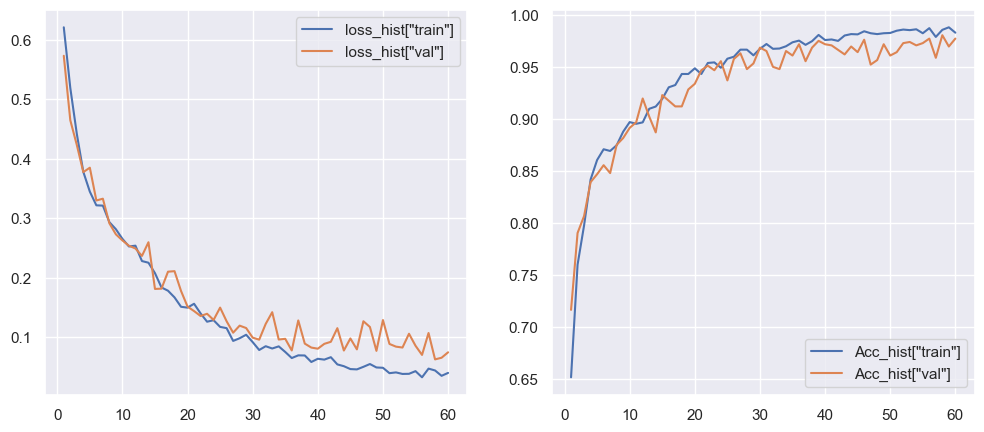

In [23]:
# Convergence History Plot
epochs=params_train["epochs"]
fig,ax = plt.subplots(1,2,figsize=(12,5))

sns.lineplot(x=[*range(1,epochs+1)],y=loss_hist["train"],ax=ax[0],label='loss_hist["train"]')
sns.lineplot(x=[*range(1,epochs+1)],y=loss_hist["val"],ax=ax[0],label='loss_hist["val"]')
sns.lineplot(x=[*range(1,epochs+1)],y=metric_hist["train"],ax=ax[1],label='Acc_hist["train"]')
sns.lineplot(x=[*range(1,epochs+1)],y=metric_hist["val"],ax=ax[1],label='Acc_hist["val"]')

Confusion_Matrix

In [29]:
# define function For Classification Report
def True_and_Pred(val_loader, model):
    model.eval()  # Set model to evaluation mode
    y_true = []
    y_pred = []
    for images, labels in val_loader:
        images = images.to(device)  # Move images to the device
        labels = labels.to(device)  # Move labels to the device
        outputs = model(images)
        _, pred = torch.max(outputs, 1)
        
        y_true.extend(labels.cpu().numpy())  # Convert labels back to cpu and numpy array
        y_pred.extend(pred.cpu().numpy())    # Convert predictions back to cpu and numpy array
    
    return y_true, y_pred

# Move the model to the same device as the input tensor
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# check confusion matrix for error analysis
y_true, y_pred = True_and_Pred(val_loader, model)

print(classification_report(y_true, y_pred), '\n\n')
cm = confusion_matrix(y_true, y_pred)


              precision    recall  f1-score   support

           0       0.98      0.98      0.98       418
           1       0.99      0.98      0.98       503

    accuracy                           0.98       921
   macro avg       0.98      0.98      0.98       921
weighted avg       0.98      0.98      0.98       921
 




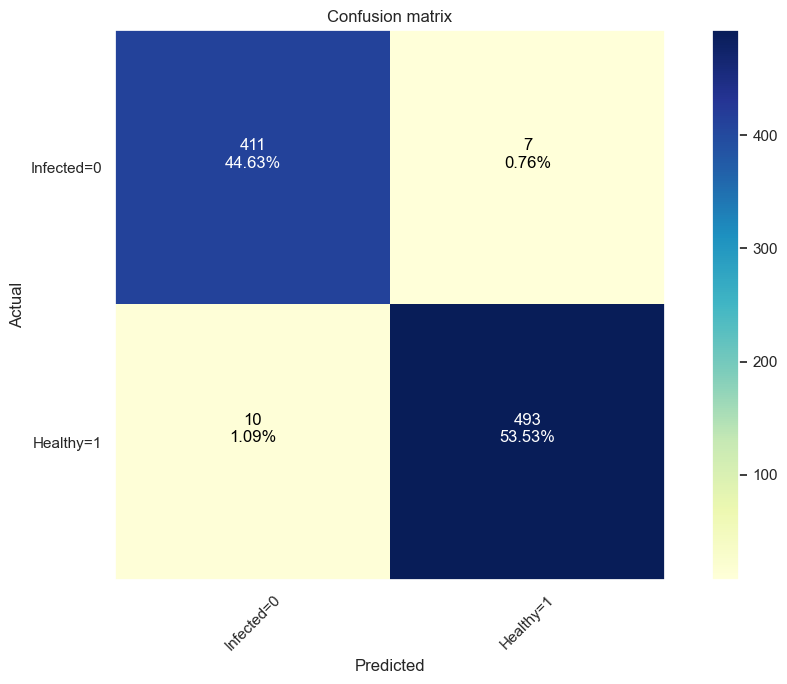

In [30]:
# Confusion Matrix Plotting Function
def show_confusion_matrix(cm, CLA_label, title='Confusion matrix', cmap=plt.cm.YlGnBu):
    
    plt.figure(figsize=(10,7))
    plt.grid(False)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(CLA_label))

    plt.xticks(tick_marks, [f"{value}={key}" for key , value in CLA_label.items()], rotation=45)
    plt.yticks(tick_marks, [f"{value}={key}" for key , value in CLA_label.items()])

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f"{cm[i,j]}\n{cm[i,j]/np.sum(cm)*100:.2f}%", horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.tight_layout()
    plt.show()

show_confusion_matrix(cm, CLA_label)

Model Saving

In [31]:
torch.save(cnn_model, "Schizophrenia_Model.pt")

In [32]:
import torch

# Load the model
model = torch.load("Schizophrenia_Model.pt")

# Ensure the model is in evaluation mode
model.eval()


CNN_Schizophrenia(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=12544, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=2, bias=True)
)

In [34]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image

# Define Architecture For CNN_TUMOR
class CNN_TUMOR(nn.Module):
    
    # Network Initialisation
    def __init__(self, params):
        
        super(CNN_TUMOR, self).__init__()
    
        Cin,Hin,Win = params["shape_in"]
        init_f = params["initial_filters"] 
        num_fc1 = params["num_fc1"]  
        num_classes = params["num_classes"] 
        self.dropout_rate = params["dropout_rate"] 
        
        # Convolution Layers
        self.conv1 = nn.Conv2d(Cin, init_f, kernel_size=3)
        h,w=findConv2dOutShape(Hin,Win,self.conv1)
        self.conv2 = nn.Conv2d(init_f, 2*init_f, kernel_size=3)
        h,w=findConv2dOutShape(h,w,self.conv2)
        self.conv3 = nn.Conv2d(2*init_f, 4*init_f, kernel_size=3)
        h,w=findConv2dOutShape(h,w,self.conv3)
        self.conv4 = nn.Conv2d(4*init_f, 8*init_f, kernel_size=3)
        h,w=findConv2dOutShape(h,w,self.conv4)
        
        # compute the flatten size
        self.num_flatten=h*w*8*init_f
        self.fc1 = nn.Linear(self.num_flatten, num_fc1)
        self.fc2 = nn.Linear(num_fc1, num_classes)

    def forward(self,X):
        
        # Convolution & Pool Layers
        X = F.relu(self.conv1(X)); 
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv3(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv4(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, self.num_flatten)
        X = F.relu(self.fc1(X))
        X = F.dropout(X, self.dropout_rate)
        X = self.fc2(X)
        return F.log_softmax(X, dim=1)


# Define the transformation for preprocessing the image
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the saved model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = torch.load("Schizophrenia_Model.pt", map_location=device)  # Load the model

# Set the model to evaluation mode
model.eval()

# Move the model to the same device as the input tensor
model.to(device)

# Move the input tensor to the same device as the model
image = image.to(device)

# Make predictions
with torch.no_grad():
    output = model(image)

# Get predicted class probabilities and class with maximum probability
predicted_probabilities = torch.exp(output)
predicted_class = torch.argmax(predicted_probabilities, dim=1).item()

# Define the class labels
class_labels = {
    0: 'Healthy',
    1: 'Schizophrenia'
}

# Print the predicted class label
print("Predicted Class:", class_labels[predicted_class])


Predicted Class: Healthy
